# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pwd

'/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/notebooks'

Identify the input files and read them in

In [3]:
namepart = "0.016_15_180_123456"#"0.06_100_12345"#_interrupted"#notravellers"
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/results_" + namepart + ".txt"


Infections available too!

In [4]:
#infections_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections" + namepart + ".txt"
#i_data = pd.read_csv(infections_filename, sep='\t')

In [4]:
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]


You can aggregate these and write them out to a file for visualisation in QGIS, if you so choose

In [5]:
r_data

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,0,0,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45
...,...,...,...,...,...,...,...,...,...,...
10795,179,d_55,0,0,0,0,0,0,NaN,55
10796,179,d_52,0,0,0,0,0,0,NaN,52
10797,179,d_53,0,0,0,0,0,0,NaN,53
10798,179,d_50,0,0,0,0,0,0,NaN,50


In [6]:
r_agg = r_data.groupby('districtId').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})
#r_agg = r_agg[r_agg['metric_new_cases_sympt'] > 5].sort_values(by='metric_new_cases_sympt', ascending=False)
#r_agg.to_csv("totalSympt.csv", sep=',')

In [7]:
r_agg[r_agg["metric_new_critical"] > 0]

,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt
districtId,,,,,
2,0,9,1,150,204
7,0,3,2,5,6
21,1,7,3,37,77
31,0,2,1,16,33
34,0,1,1,5,8
36,0,4,1,31,59
38,0,2,1,43,78


Lazier aggregation also available

In [8]:
sum(r_data['metric_new_cases_sympt'])

672

## Graphing the outbreak curves

In [25]:
r_cum = r_data.groupby('time').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})
r_cum["index"] = r_cum.index
r_cum

,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,index
time,,,,,,
0,0,0,0,83,97,0
1,0,0,0,0,0,1
2,0,0,0,0,0,2
3,0,0,0,0,0,3
4,0,0,0,0,0,4
...,...,...,...,...,...,...
175,1,0,0,1,6,175
176,1,0,1,0,1,176
177,1,0,0,0,2,177


Country-level

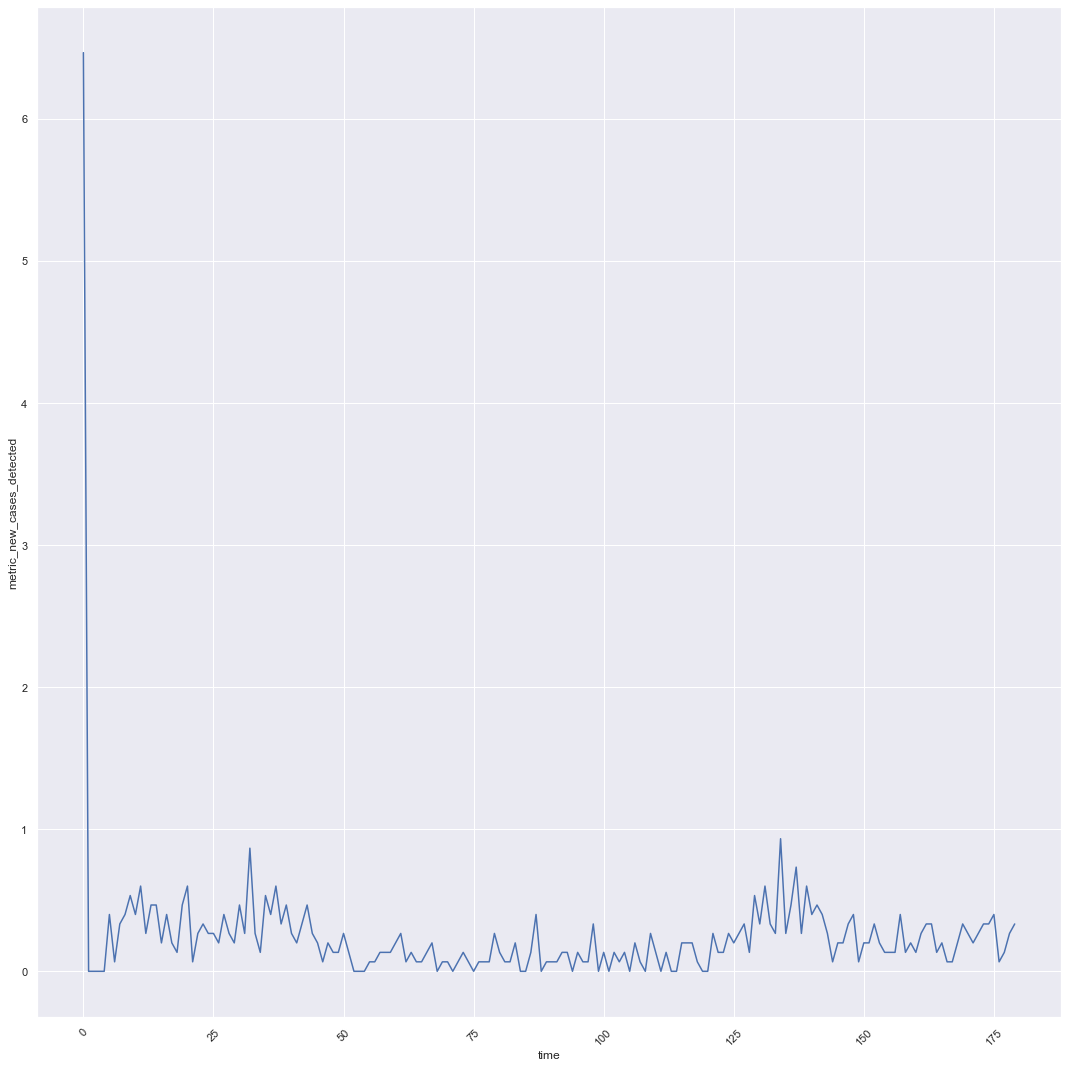

In [11]:
r_country_agg = r_data.groupby('time').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})

lineListWeightingFactor = 15
r_country_agg['metric_new_cases_detected'] = r_country_agg['metric_new_cases_sympt'] / lineListWeightingFactor

#sns.scatterplot(
fig, ax = plt.subplots (figsize = (15,15))
sns.lineplot(
             x="time", 
             #y="metric_new_deaths",
             #y="metric_new_hospitalized",
             y="metric_new_cases_detected", 
             palette="colorblind", 
             ax = ax,
             data=r_country_agg#,
#            legend=False
            )#.legend(bbox_to_anchor= (1.03, 1) )

#ax.set_title('New Deaths', fontsize=20)
#ax.set_ylabel('Number of deaths')
#ax.legend(fontsize=10, title_fontsize=30, loc='upper left')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Mapping results

In [4]:
import geopandas
import math

In [112]:
#path_to_data = geopandas.datasets.get_path()
rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")

Join this with the previous data!

In [14]:
dataLocs = rawLocs.merge(r_agg, how="left", left_on=['ID_2'], right_on=['districtId'])

In [16]:
dataLocs["log_died"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_died_count"]]
dataLocs["log_sympt"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_new_cases_sympt"]]


<AxesSubplot:>

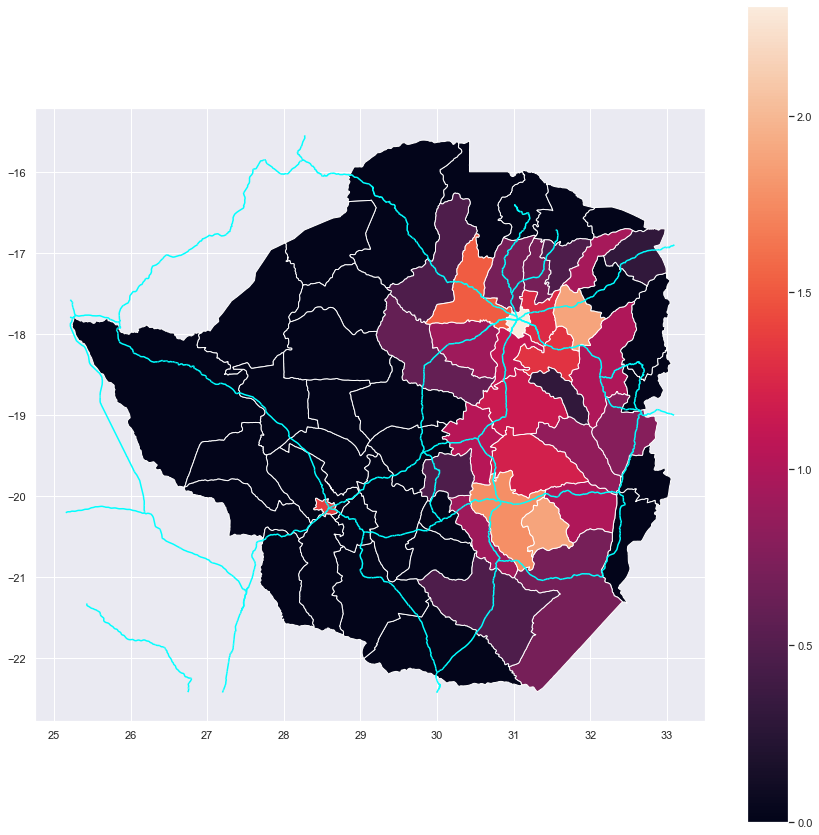

In [17]:
fig, ax = plt.subplots (figsize = (15,15))
#dataLocs.plot("metric_new_cases_sympt", ax = ax, legend=True)
dataLocs.plot("log_sympt", ax = ax, legend=True)

trunkRoads.plot(ax=ax, color="cyan")


COMPARE TO [this](https://ourworldindata.org/covid-deaths)

## Ordering of Districts

### Observing while running

Progress can be observed as they're running - just add the file to which the simulation is exporting below!

**NOTE: MAKE SURE YOU HAVE A TEXT FILE IN THE SAME DIRECTORY AS THIS FILE CONTAINING THE 'TRUE' ORDER OF FILES!**

This file should be formatted as follows:

```
day	districtId
1	1
1	2
...
```

Please note that it is TAB DELIMITED - if your data is not, then you will need to update the csv readin below.

In [130]:
# set my path when running the file from here

from os.path import isfile, join
path = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/'

# read and clean the data
results_filename = (path+'exportMe9927.txt')
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]] # she is renaming districtid myId


# filter out case data
cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
cases.head()

# group by districts and sort by time
byDistric = cases.groupby('districtId').agg({'time': 'min'})
byDistric.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
byDistric.rename(columns={'time':'simDay'}, inplace=True)

byDistric.head()

# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## Sophie not using this 

# join the simulated and gold standard data based on the district ID
comparison = g_data.join(byDistric, on='districtId', lsuffix='_gold', rsuffix='_sim')
comparison['simDay'] = comparison['simDay'].fillna(0) # you may wish to set the unfound districts to some default
#comparison # show the results
comparison.head()
comparison.to_csv(path+'comparison.csv')

In [61]:
myslice = pd.isna(comparison['simDay']) # see all of the districts where there were cases in both sim and true days 
#print(comparison[-myslice]) # showing the districts where the cases occured in both simulation and true data
both_sa= comparison[-myslice]
myslice.head()

0    False
1    False
2    False
3    False
4    False
Name: simDay, dtype: bool

/opt/anaconda3/envs/i2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


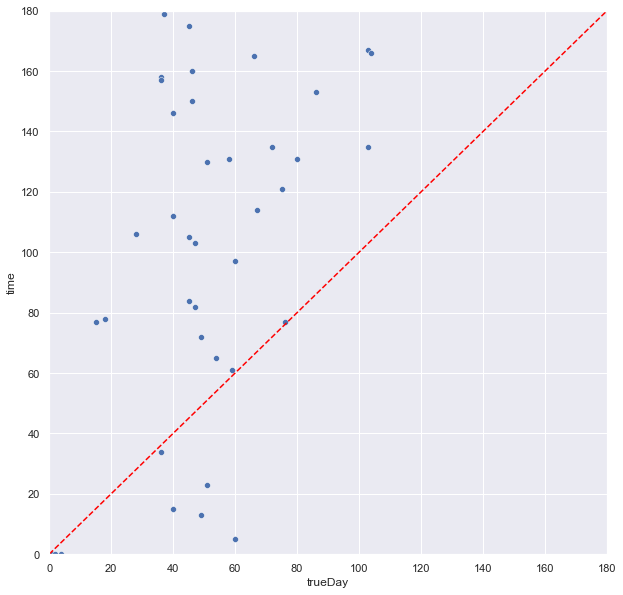

In [131]:
fig, ax = plt.subplots (figsize = (10,10))
ax= sns.scatterplot(
             x="trueDay", 
             y="simDay",
             #y="metric_new_hospitalized",
             #y="metric_new_cases_sympt", 
             palette="colorblind", 
            # hue="districtId",
             data=comparison, #,
            #legend=True
            )#.legend(bbox_to_anchor= (1.03, 1) )

 # add labels to values on product id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')

ax.set(xlim=(0, 180), ylim=(0, 180)) # in true day the max first day is 136, in sim the max first day is 179
xl, yl = [0,180], [0,180]
sns.lineplot(xl, yl, linestyle='--', color='red')

### Summarising the results

Sets of simulation results can also be explored in the aggregate.

In [97]:
outputFiles = ["exportMe9927.txt"]#"exportMe3324.txt", "exportMe4725.txt", "exportMe9812.txt", "exportMe2439.txt", "exportMe5343.txt", 
               #"exportMe6598.txt", "exportMe8992.txt", "exportMe7535.txt", "exportMe217.txt", "exportMe217.txt"]


In [98]:
# a helper function to read in and order a set of districts
def getOrderedDistricts(filename):
    
    # read and clean the data
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    
    # select the relevant columns, either cases or deaths
    cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
    #cases = r_data[r_data.metric_new_deaths > 0]
    
    # group by districts and sort by time
    byDistric = cases.groupby('districtId').agg({'time': 'min'})
    byDistric.sort_values(by="time")
    return byDistric
    
# read in the gold standard data
gold_filename = "true.txt"
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']]

In [101]:
# iterate through the set of exported results files and append them to one another

simRuns = pd.NA # intial empty file

for x in outputFiles: # iterating over files
    try:
        simRuns = simRuns.append(getOrderedDistricts(x))
    except:
        simRuns = getOrderedDistricts(x)

# aggregate by the mean time associated with the district
simAgg = simRuns.groupby('districtId').agg({'time': 'mean'})

In [107]:
# additional helper functions

def getAggDailyCounts(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    dailies = r_data.groupby('time').agg({'metric_new_cases_sympt': 'sum', 'metric_new_cases_asympt': 'sum'})
    dailies.sort_values(by="time")
    return dailies

def getRawData(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return r_data

simRuns = pd.NA

for x in outputFiles:
    myCounts = getRawData(x)
    myCounts['key'] = [x for i in range(len(myCounts))]
    try:
        simRuns = simRuns.append(myCounts)
    except:
        simRuns = myCounts

simAgg = simRuns.groupby('time').agg({'metric_new_cases_sympt': 'mean', 'metric_new_cases_asympt': 'mean'})
simAgg.head()

,metric_new_cases_sympt,metric_new_cases_asympt
time,,
0,0.133333,0.2
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0


### Mapping the difference between simulated and true timing

In [132]:
# calculate the delta between true and simulated first recorded cases
comparison['diff'] = comparison['trueDay'] - comparison['simDay']

# read in spatial data
rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")

# merge the comparison data with the spatial district data on the district ID
dataLocs = rawLocs.merge(comparison, how="left", left_on=['ID_2'], right_on=['districtId'])

Red = simulated was faster than real

Blue = simulated was slower than real

<AxesSubplot:>

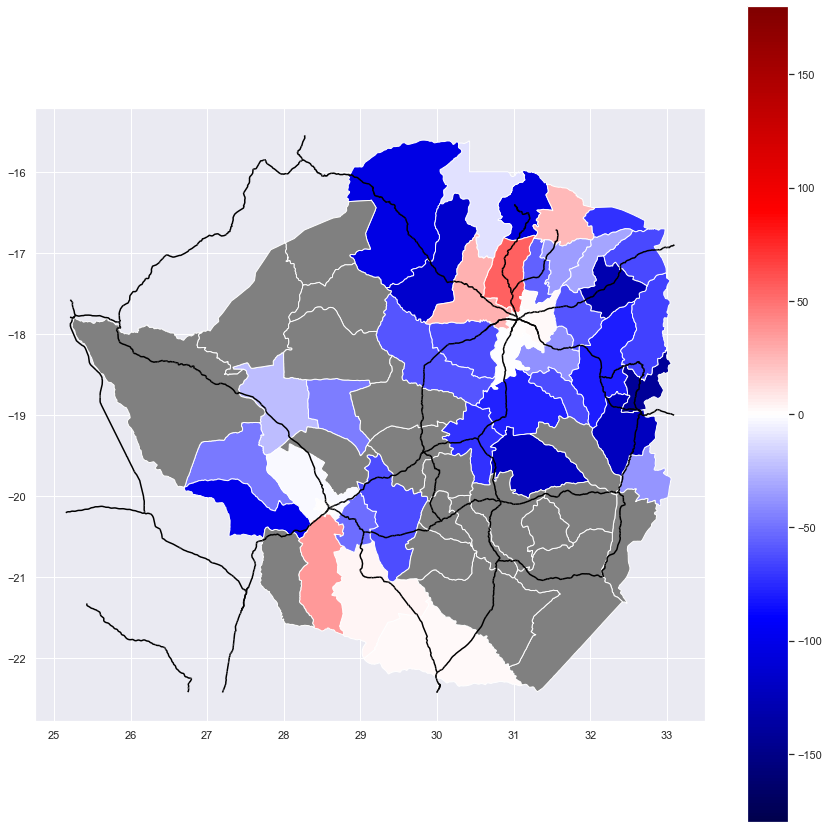

In [133]:
myLim = 180

fig, ax = plt.subplots (figsize = (15,15))
dataLocs.plot("diff", ax = ax, legend=True, cmap='seismic', 
              missing_kwds={"color": "gray", "label": "Missing values",}, vmin=-myLim, vmax=myLim)

trunkRoads.plot(ax=ax, color="black")